In [6]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Optional

In [14]:
# Physics (model)

@dataclass
class HydrogenAtom:
    """
    A model of the Hydrogen atom to calculate spectral lines.
    
    Attributes:
        rydberg_const (float): The Rydberg constant in m^-1.
    """
    rydberg_const: float = 1.097373e7

    def photon_wavelength(self, n_lower: int, n_upper: int) -> float:
        """
        Calculate emission wavelength in nanometers.
        """
        if n_upper <= n_lower:
            raise ValueError(f"Emission requires n_upper ({n_upper}) > n_lower ({n_lower})")
            
        # 1/lambda = R * (1/n_lower^2 - 1/n_upper^2)
        inverse_lambda = self.rydberg_const * (1/n_lower**2 - 1/n_upper**2)
        return (1 / inverse_lambda) * 1e9  # Return in nm

    def get_series(self, series_name: str, max_n: int = 10) -> Dict[str, float]:
        """
        Generate spectral lines for a named series (Lyman, Balmer, Paschen).
        """
        series_map = {
            "Lyman": 1,
            "Balmer": 2,
            "Paschen": 3,
            "Brackett": 4
        }
        
        if series_name not in series_map:
            raise KeyError(f"Unknown series: {series_name}. Available: {list(series_map.keys())}")
            
        n_base = series_map[series_name]
        lines = {}
        
        for n in range(n_base + 1, max_n + 1):
            wl = self.photon_wavelength(n_base, n)
            lines[f"n={n}->{n_base}"] = wl
            
        return lines

    def doppler_shift(self, wavelength_nm: float, velocity_kms: float) -> float:
        """
        Applies the Doppler effect to a wavelength.
        """
        c_kms = 2.99792e5
        return wavelength_nm * (1 + velocity_kms / c_kms)

    def energy_level(self, n: int) -> float:
        """
        Calculate the energy of level n in electron-volts (eV).
        Formula: E_n = -13.6 eV / n^2
        """
        return -13.6 / n**2

    def transition_energy(self, n_lower: int, n_upper: int) -> float:
        """
        Calculate the energy difference (photon energy) in eV.
        """
        e_upper = self.energy_level(n_upper)
        e_lower = self.energy_level(n_lower)
        return e_upper - e_lower

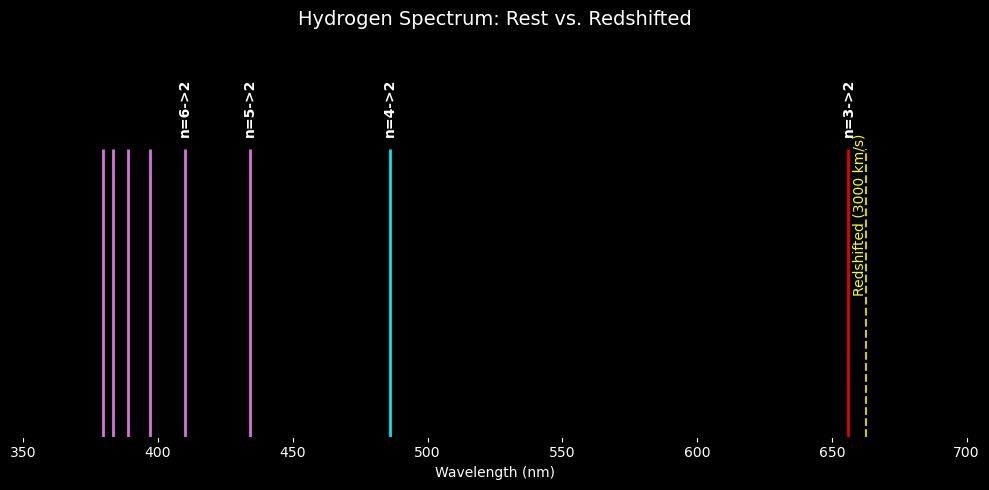

In [10]:
# 2. Visualization

# 1. Instantiate the physics model
atom = HydrogenAtom()

# 2. Get the data
# Let's get the Balmer series (Visible light)
balmer_lines = atom.get_series("Balmer")

# 3. Setup the plot
fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')
ax.set_facecolor('black')

# 4. Plot the lines
for transition, wl in balmer_lines.items():
    # Color logic: Map wavelength to approximate RGB color
    color = 'red' if wl > 620 else 'cyan' if wl > 480 else 'violet'
    
    # Draw the spectral line
    ax.vlines(wl, 0, 1, colors=color, lw=2, alpha=0.9)
    
    # Label the major lines (H-alpha, H-beta)
    if wl > 400:  # Only label visible ones
        ax.text(wl, 1.05, transition, color='white', rotation=90, 
                ha='center', fontsize=10, fontweight='bold')

# 5. Add "The Doppler Challenge" (Preview for Session 5)
# Let's simulate a star moving AWAY at 3000 km/s (Redshift)
h_alpha_rest = balmer_lines['n=3->2']
h_alpha_shifted = atom.doppler_shift(h_alpha_rest, velocity_kms=3000)

ax.vlines(h_alpha_shifted, 0, 1, colors='yellow', linestyles='--', alpha=0.8)
ax.text(h_alpha_shifted, 0.5, 'Redshifted (3000 km/s)', color='yellow', rotation=90, ha='right')

# Aesthetics
ax.set_xlim(350, 700)
ax.set_ylim(0, 1.4)
ax.set_xlabel("Wavelength (nm)", color='white')
ax.set_title("Hydrogen Spectrum: Rest vs. Redshifted", color='white', fontsize=14)
ax.tick_params(axis='x', colors='white')
ax.set_yticks([]) # Hide Y axis

plt.tight_layout()
plt.show()

In [15]:
# Instantiate
atom = HydrogenAtom()

# Calculate Energy for H-alpha (3 -> 2)
n_upper = 3
n_lower = 2

E_upper = atom.energy_level(n_upper)
E_lower = atom.energy_level(n_lower)
Delta_E = atom.transition_energy(n_lower, n_upper)

print(f"--- H-alpha Transition Analysis ---")
print(f"Energy at n={n_upper}: {E_upper:.3f} eV")
print(f"Energy at n={n_lower}: {E_lower:.3f} eV")
print(f"Photon Energy (ΔE):  {Delta_E:.3f} eV")

# Validation: Convert eV to Wavelength (lambda = hc / E)
# hc = 1239.8 eV nm
lambda_check = 1239.8 / Delta_E
print(f"Calculated Wavelength: {lambda_check:.2f} nm (Expected: ~656.3 nm)")

--- H-alpha Transition Analysis ---
Energy at n=3: -1.511 eV
Energy at n=2: -3.400 eV
Photon Energy (ΔE):  1.889 eV
Calculated Wavelength: 656.36 nm (Expected: ~656.3 nm)


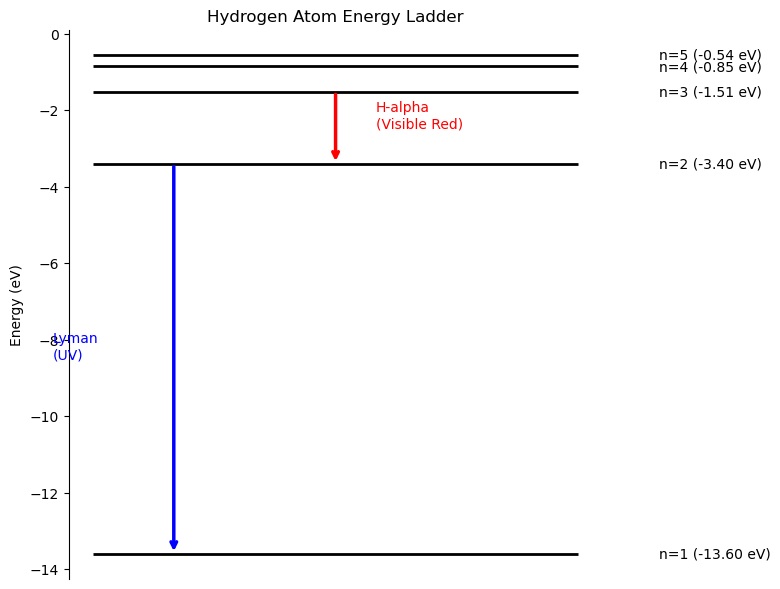

In [18]:
# Plotting the energy levels

# Define levels to plot
atom = HydrogenAtom()

# Create the figure (Standard White Background for safety)
fig, ax = plt.subplots(figsize=(8, 6))

# Define levels to plot (n=1 to n=5)
levels = range(1, 6)
center = 1.0
x_width = 0.6

# Draw the energy levels
for n in levels:
    E = atom.energy_level(n)
    # Draw horizontal line
    ax.hlines(E, center - x_width/2, center + x_width/2, colors='black', lw=2)
    # Label the line
    ax.text(center + x_width/2 + 0.1, E, f"n={n} ({E:.2f} eV)", 
            verticalalignment='center', color='black', fontsize=10)

# Draw the H-alpha Arrow (n=3 down to n=2)
E3 = atom.energy_level(3)
E2 = atom.energy_level(2)
ax.annotate("", xy=(center, E2), xytext=(center, E3),
            arrowprops=dict(arrowstyle="->", color='red', lw=2.5))
ax.text(center + 0.05, (E3+E2)/2, "H-alpha\n(Visible Red)", color='red', fontsize=10)

# Draw Lyman Arrow (n=2 down to n=1)
E1 = atom.energy_level(1)
ax.annotate("", xy=(center - 0.2, E1), xytext=(center - 0.2, E2),
            arrowprops=dict(arrowstyle="->", color='blue', lw=2.5))
ax.text(center - 0.35, (E2+E1)/2, "Lyman\n(UV)", color='blue', fontsize=10)

# Formatting
ax.set_ylabel("Energy (eV)")
ax.set_title("Hydrogen Atom Energy Ladder")
ax.set_xticks([]) # Hide x-axis ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()